The Product & Technology team (P&T) at OfficeDepot, has a B2B system called webMethods. This system works 24/7 receving and sending transactions with external customers/vendors around the world. 

During the weekend of April 24th, there was a maintenance in some other servers not controled by the P&T team, which caused the webMethods applications not to be able to connect to the database. All transactions not processed by webMethods, were pilling up, and after the weekend, all of them had to be resubmitted.

Management wants to find a way to implement some sort of notification in case there is a sudden spike on errors, even during the weekend.

In [1]:
#Import section
from datetime import date
import os
import pandas as pd
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import seaborn as sns

%matplotlib inline

This is the log file produced by webMethods server during that weekend

In [2]:
#File to process
logs_dir = 'chib2bprdcst06 Logs 25 & 26 April 2021/'
files_name = 'WMERROR_20210425_055521.log'

#logs_dir = 'From TEST/'
#files_name = 'WMERROR_20210601_000007.log'

In [3]:
#Reading the file into a list of array of error messages
error_messages = []
array_error = []
with open((logs_dir+files_name),'r') as fp:
    fileline = fp.readline()
    while fileline:
        if fileline.startswith("WMERROR"):
            error_messages.append(array_error)
            array_error = []
            array_error.append(fileline)
        else:
            array_error.append(fileline)
        fileline = fp.readline()
    error_messages.append(array_error)
if error_messages[0] == []:
    error_messages.pop(0)

In [4]:
#Transforming the array of error messages into a DataFrame
cols = ['Type','Root Context','FieldNull','Parent Context','Current Context','ServerId','Timestamp1','Timestamp2','error_message','ServiceName','ServiceStack']
logs_df = pd.DataFrame(columns = cols)

for error in error_messages:
    row_cols = []
    for i, row in enumerate(error):
        if(i == 0):
            row_cols = row.split(None, 8)
        else:
            #This is the last line of the error
            if(i == len(error) - 1):
                row_cols[8] = row_cols[8] + row
                truncatedIndex = row_cols[8].find('...<truncated>',len(row_cols[8])//2)
                if(truncatedIndex >= 0):
                    truncatedIndex = truncatedIndex + 14
                    last2col = row_cols[8][truncatedIndex:].split(None, 1)
                    row_cols[8] = row_cols[8][:truncatedIndex]
                    row_cols = row_cols + last2col
                else:
                    last2col = row.rsplit(None, 2)
                    row_cols = row_cols + last2col[-2:]
            else:
                row_cols[8] = row_cols[8] + row
    logs_df.loc[len(logs_df)] = row_cols

This is the content of the file.

The errors started on April 25 at 9:55 am, and continued after midnight.

In [5]:
#Enhancing the dataframe content
logs_df['Timestamp1'] = pd.to_datetime(logs_df['Timestamp1'])
logs_df['Timestamp2'] = pd.to_datetime(logs_df['Timestamp2'])
logs_df = logs_df.set_index('Current Context')
logs_df.head()

,Type,Root Context,FieldNull,Parent Context,ServerId,Timestamp1,Timestamp2,error_message,ServiceName,ServiceStack
Current Context,,,,,,,,,,
528f8830-2472-28b1-132e-35798d5a5ac7,WMERROR,a77dd991-ce10-4576-9112-69cd24fb5ea1, ,a77dd991-ce10-4576-9112-69cd24fb5ea1,Chib2bprdcst06.uschecom.net:5080,2021-04-25 09:55:20.926000+00:00,2021-04-25 09:55:21.473000+00:00,[ISS.0098.9006] No matching Document Type exis..., , 
52e12b83-f71d-51e9-7542-8d2c096ee314,WMERROR,7ae35f59-64ac-43b8-8972-810c9b8ed4fd, ,7ae35f59-64ac-43b8-8972-810c9b8ed4fd,Chib2bprdcst06.uschecom.net:5080,2021-04-25 09:55:20.926000+00:00,2021-04-25 09:55:21.489000+00:00,[ISS.0098.9006] No matching Document Type exis..., , 
f15b1684-dde2-f0f2-c968-15f1cf9389f3,WMERROR,16996f2b-1875-45fc-9736-dbff04c94008, ,16996f2b-1875-45fc-9736-dbff04c94008,Chib2bprdcst06.uschecom.net:5080,2021-04-25 10:03:53.345000+00:00,2021-04-25 10:03:53.728000+00:00,Trading Networks could not retrieve data from ...,wm.tn.admin:startup, 
943f3a61-a33e-bba9-df59-a76d5186b74c,WMERROR,68f0653e-c6fd-4649-8e79-88889502eef6, ,68f0653e-c6fd-4649-8e79-88889502eef6,Chib2bprdcst06.uschecom.net:5080,2021-04-25 10:03:57.404000+00:00,2021-04-25 10:03:57.734000+00:00,<EXMLException>\n <ErrorCode></ErrorCode>\n ...,wm.tn.docattr:add,wm.tn.docattr:add ...
ea62f677-1696-c12d-471c-7e78a0220e24,WMERROR,332402d4-42fd-4396-81d0-890ceaa3200f, ,332402d4-42fd-4396-81d0-890ceaa3200f,Chib2bprdcst06.uschecom.net:5080,2021-04-25 10:03:57.405000+00:00,2021-04-25 10:03:57.734000+00:00,<EXMLException>\n <ErrorCode></ErrorCode>\n ...,wm.EDIINT.util:init,wm.tn.docattr:add\nwm.EDIINT.util:init ...


In [6]:
logs_df.shape

(225, 10)

In [7]:
cv_support_df = logs_df[['Timestamp1','ServiceName']]

In [8]:
logs_df_by_hr = cv_support_df.groupby(cv_support_df['Timestamp1'].dt.ceil('H')).count()
logs_df_by_hr = logs_df_by_hr.drop(columns=['Timestamp1'])
logs_df_by_hr.columns = ['ErrorCountInHr']

idx = pd.date_range(logs_df_by_hr.iloc[0].name, logs_df_by_hr.iloc[-1].name, freq="H")
logs_df_by_hr = logs_df_by_hr.reindex(idx, fill_value=0)

In order to analize when we got a spike of errors worth sending an alert out, I am using the empirical rule of covering 95% of the cases under two standard deviations above the mean, and setting the alert if the errors goes above that threshold

In [9]:
logs_df_by_hr['mean'] = logs_df_by_hr['ErrorCountInHr'].expanding(2).mean()
logs_df_by_hr['std'] = logs_df_by_hr['ErrorCountInHr'].expanding(2).std()
logs_df_by_hr['threshold'] = logs_df_by_hr['ErrorCountInHr'].expanding(2).mean() + 2*logs_df_by_hr['ErrorCountInHr'].expanding(2).std()
logs_df_by_hr = logs_df_by_hr.reset_index()
logs_df_by_hr.head(5)

,index,ErrorCountInHr,mean,std,threshold
0,2021-04-25 10:00:00+00:00,2,NaN,NaN,NaN
1,2021-04-25 11:00:00+00:00,10,6.0,5.656854,17.313708
2,2021-04-25 12:00:00+00:00,0,4.0,5.291503,14.583005
3,2021-04-25 13:00:00+00:00,0,3.0,4.760952,12.521905
4,2021-04-25 14:00:00+00:00,42,10.8,17.922053,46.644107


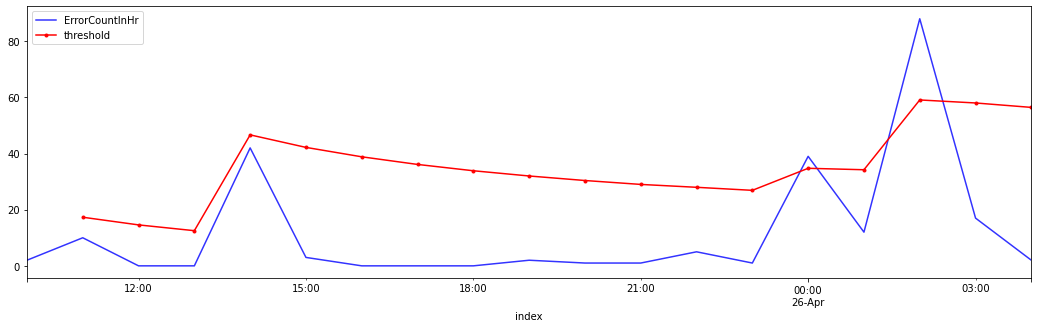

In [10]:
#ax = logs_df_by_hr[['index','threshold']].plot(x='index', linestyle='-', marker='', color='orange')
plt.rcParams["figure.figsize"] = (18,5)
ax = logs_df_by_hr[['index','ErrorCountInHr']].plot(x='index', alpha=0.8, color='blue')
logs_df_by_hr[['index','threshold']].plot(x='index', linestyle='-', marker='.', color='red', ax=ax)
plt.show()

As we can see in the graph, there was a spike at hour 14th, but it was not worth asking someone to log in during the weekend, since the errors did not continue after that. But at midnight, we had another spike, which would have triggered the notification. Another notification would have been triggered at 2 am EST on April 26th. Most likely the people in India would have taken the alert and do some action.